# Dynamical Friction

A characteristic feature of a stellar system is the transfer of energy from their orbits to the dynamical motion of its constituents. We can consider a body whose mass $M$ traveling through a population of stars whose masses can be assumed equal $m_\mathrm{S}$ to one another. Usually the system's mass $\mathcal{M} \gg M$, the interaction with the stars can be described by means of the $\textbf{diffusion coefficients}$ that I here report only as results (see Binney and Tremaine's "Galactic Dynamics", §7.4.4 for further details). 

$$D[\Delta v_i] = 4\pi G^2 m_S (m+m_S) \ln{\Lambda} \frac{\partial}{\partial v_i} h(x, v)$$

$$D[\Delta v_i] = 4\pi G^2 m_S^2 \ln{\Lambda} \frac{\partial^2}{\partial v_i \partial v_j} g(x, v)$$

$h(x, v)$ and $g(x, v)$ are the Rosenbluth potentials:

$$h(x,v) = \int d^{3}v_S \frac{f_S(x, v_S)}{|v - v_S|}$$

$$g(x,v) = \int d^{3}v_S f_S(x, v_S)|v - v_S|$$

An idea of what the effect of other masses is is given by the following pictures (credit: https://lukeleisman.substack.com/p/walk-on-water-further-reflections)

<img src="before.png" align="center" width="400px"/>

<img src="after.png" align="center" width="400px"/>

All the previous equations need to be set in the limit $m \gg m_S$.
Thus, the first order coefficients are much larger than the second order ones. The rate of deceleration is usually indicated as: 

$$\frac{dv_{M}}{dt} = D[\Delta v] = -4\pi G^2 M m_S \ln{\Lambda} \int d^{3}v_S f(v_S) \frac{v_M - v_S}{|v_M - v_S|}$$

where $\Lambda \sim \frac{b_{\mathrm{max}}}{b_{90}}$, $b$ being the impact parameter. 
In a field where stars have an $\textbf{isotropic}$ velocity distribution we have the simple expression (Chandrasekhar's dynamical friction formula): 

$$\frac{dv_{M}}{dt} = -16\pi^2 G^2 M m_S \ln{\Lambda} \frac{v_M}{|v_M|^3} \int dv_S v_S^{2} f(v_S)$$

- If $v_M$ is very slow, we can replace $\int dv_S v_S^{2} f(v_S) = f(0)$, and write: 

$$\frac{dv_{M}}{dt} \simeq -\frac{16\pi^2}{3} G^2 M m_S \ln{\Lambda}f(0)v_M $$

This case is very similar to Stokes force we know from basic mechanics in fluids. 

- If $v_M$ is very high, we can replace $\int dv_S v_S^{2} f(v_S) \to n / 4\pi$, and write: 

$$\frac{dv_{M}}{dt} = -4\pi^2 G^2 M m_S n \ln{\Lambda} \frac{v_M}{|v_M|^3}$$

The drag force $\textit{grows}$ as the velocity increases.

- If $f(v_S)$ is Maxwellian, we find the following solution: 

$$\frac{dv_{M}}{dt} = -\frac{4\pi^2 G^2 M m_S n \ln{\Lambda}}{|v_M|^3} ( \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}}\mathrm{e}^{-X^{2}} )$$

We can see that the DF is proportional to the mass density of stars being scattered, but independent of the mass of a single star. The acceleration is proportional to $M$, and thus the force must be proportional to $M^{2}$. 

# Our goal

We would like to simulate the dynamical friction on a massive perturber (like a black hole) on a system at equilibrium, which we initialized as a Plummer Sphere.

<img src="sphere_1.gif" align="center" width="600px"/>

An animation was produced and the result is hereby reported.

In [1]:
import matplotlib
import numpy as np
import scipy
import math
import random
import os
import time
import glob
import pandas as pd
import scipy.integrate as integrate
import scipy.special as special
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

We started this simulation by initializating the particle positions following a Plummer sphere. We set the number of particles equal to $10^4 +1$ ($1$ being the perturber's mass) and arbitrarly choose to set the total mass and the mass of the perturber.

### Setting the constants of the problem

Here we set the number of stars, and the masses of the stars and the perturber. One can arbitrarily change the mass to see the effect of increasing its value, possibly verifying one of the dependencies we discussed above. 

In [2]:
M = 1
N = 10**4 + 1
b = 1
m = M/N * np.ones(N)
G = 1
m_bh = 0.03*M
M = m_bh + m*(N-1)
m[0] = 0*m[0] + m_bh # masses array; perturber is in 0

### Initial positions

The Plummer sphere has a density profile (see the "Plummer sphere equilibrium" folder for further info)
$$ \rho \left( R \right) = \frac{3 M_{tot}}{4\pi b^3}  \frac{1}{\left[1 + \left(\frac{r^2}{b^2}\right)\right]^{5/2}}$$ 
Inverting the relation for $M \left(R \right)/M_{tot}$ we obtain that 
$$
\begin{cases}
    R = b \sqrt{\left( \frac{ \xi^{2/3}}{1-\xi^{2/3}}\right)} && 0 \le \xi \le 1 \\ \\
    \varphi = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    \theta = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$

Initially, we defined the parameters: $\phi$, $\theta$ and the radius, we then plotted their distributions in three graphs.

In [3]:
r_cdf = np.random.uniform(0,1,N)
R = b * np.sqrt(r_cdf**(2/3)/(1- r_cdf**(2/3)))
theta_cdf = np.random.uniform(0,1,N)
theta = np.arccos(1 - 2 * theta_cdf)
phi = np.random.uniform(0, 2 * np.pi, size=N) 

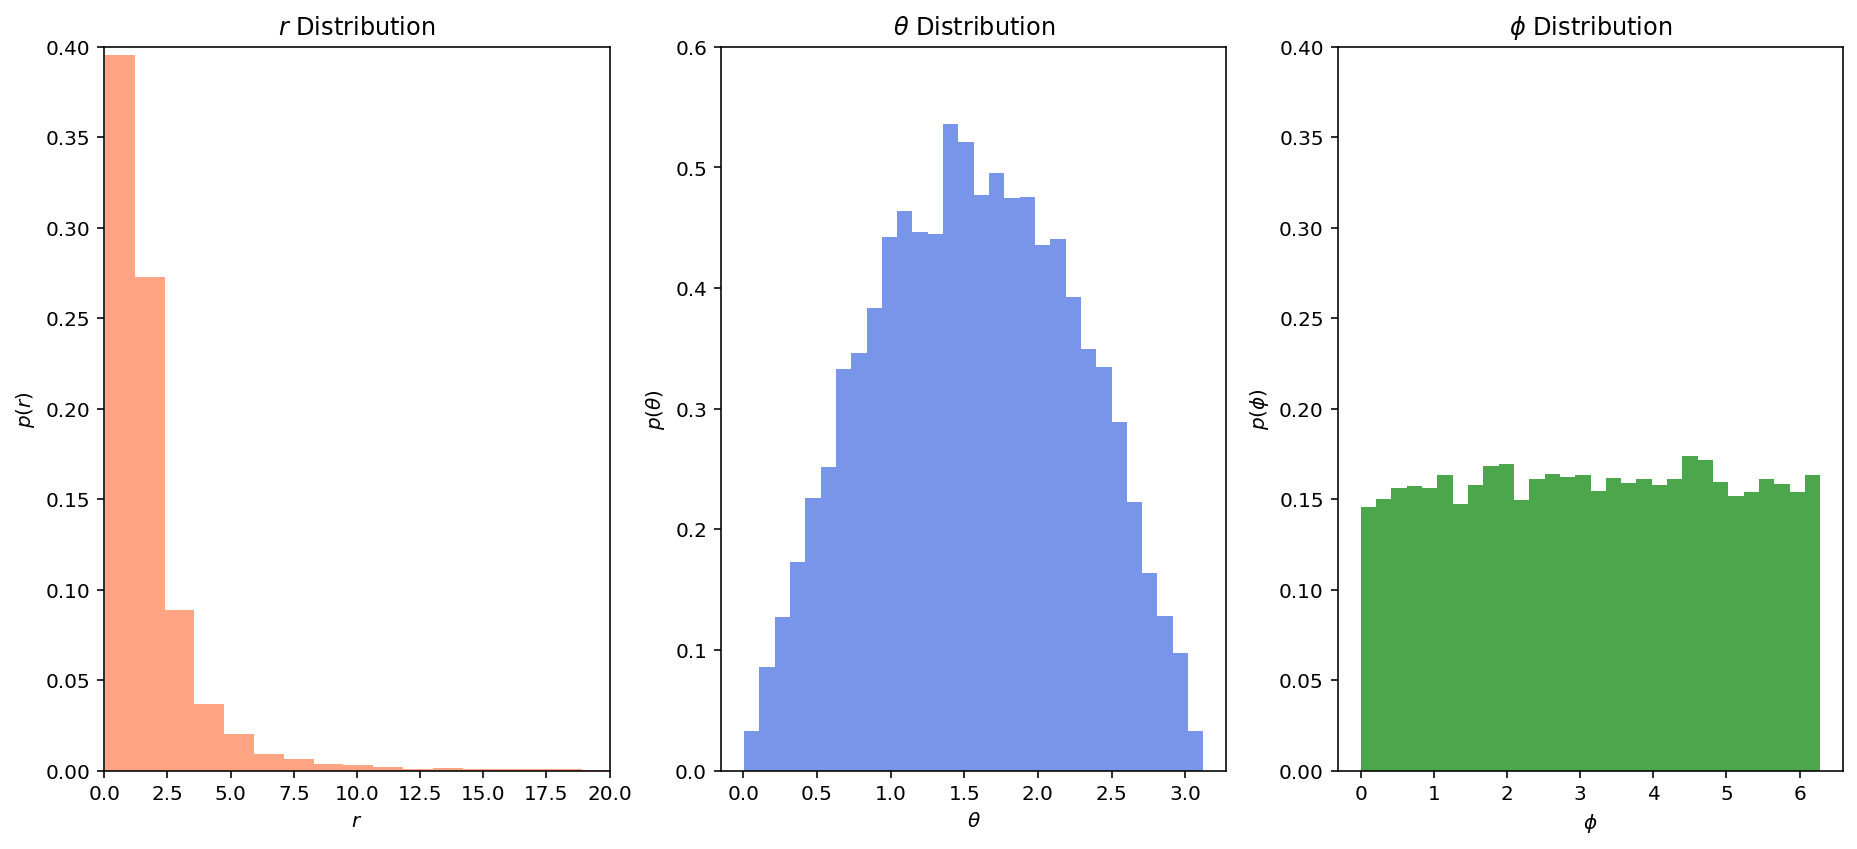

In [4]:
#Distribution of the three parameters in histograms
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(13, 6)) 

ax[0].hist(R, bins = 100, color = 'coral', density=True, alpha=.7, lw=0) 
ax[0].set(xlim=(0,20), ylim = (0,0.40), title = fr'$r$ Distribution', xlabel = r'$r$', ylabel=r'$p(r)$') 

ax[1].hist(theta, bins = 30, color = 'royalblue', density=True, alpha=.7, lw=0)
ax[1].set(ylim = (0,0.6), title = fr'$\theta$ Distribution', xlabel = r'$\theta$', ylabel=r'$p(\theta)$')

ax[2].hist(phi, bins = 30, color = 'green', density=True, alpha=.7, lw=0)
ax[2].set(ylim = (0,0.4), title = fr'$\phi$ Distribution', xlabel = r'$\phi$', ylabel=r'$p(\phi)$')
plt.show()

Write the parameters positions in cartesian coordinates for the input of the code.

In [5]:
x = R * np.cos(phi) * np.sin(theta)
y = R * np.sin(phi) * np.sin(theta)
z = R * np.cos(theta)

We show the 3D graph of our simulation, in purple the Plummer Sphere and in black the BH.

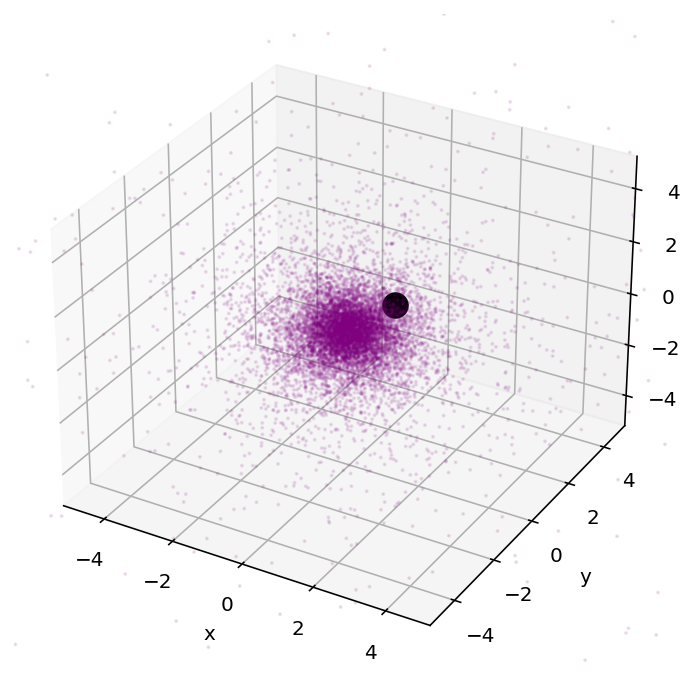

In [6]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_zlim(-5,5)
ax.scatter(x[0], y[0], z[0], c = 'black', s= 0.5*m_bh/m[1], alpha=1)
ax.scatter(x, y, z, c = 'purple', s=1, alpha=0.1)
ax.set_aspect('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show();

The potential for the Plummer sphere is:

$$\phi=\frac{-GM_{tot}}{\sqrt{r^2+b^2}}$$
The relative potential is:
$$\psi=-\phi+\phi_0=-\phi$$
We setted $\phi_0$ as zero.

In [7]:
Psi = G * M /(R**2 + b**2)**(1/2)

### Initial velocities
The velocity distribution is isotropic. For bound orbits $\vert \vec{v} \vert = q \sqrt{\Psi}$, where  $\Psi\left(\vec{x}\right) = -\phi\left(\vec{x}\right)$ and  $q$ is a position indipendent random number distributed with 
$$
 f(q) = A q^2 \left(1-q^2\right)
$$
- Compute the normalization constant
- sample q with the Montecarlo rejection method
- Compute the magnitude of the velocities.  $\vert \vec{v} \vert = q \sqrt{\Psi}$
Since the distribution is isotropic, it should form a sphere in velocity space.



$$
\begin{cases}
   \vert \vec{v} \vert = q \sqrt{\Psi} &&  0 \le q \le 1  && \text{with $f(q)$} \\ \\
    v_{\varphi} = \tilde{\varphi} && 0 \le \tilde{\varphi} \le 2 \pi \\ \\
    v_{\theta} = \arccos(1-2 \omega) &&  0 \le \omega \le 1 
\end{cases}
$$


To switch to Cartesian coordinates, we use the following change of coordinates.

$$
\begin{cases}
   v_{x} = \vert \vec{v} \vert \cos(v_{\varphi}) \sin(v_{\theta}) \\
   v_{y} = \vert \vec{v} \vert \sin(v_{\varphi}) \sin(v_{\theta}) \\
   v_{z} = \vert \vec{v} \vert  \cos(v_{\theta})
\end{cases}
$$

In [8]:
pdf_test = lambda x: (x**2*(1-x**2)**(3.5))
A = integrate.quad(pdf_test,0,1)
q = np.linspace(0,1,100000)
pdf = 1/A[0]*(q**2*(1-q**2)**(3.5))
pdf_func = lambda x: 1/A[0]*(x**2*(1-x**2)**(3.5))
g = np.ones(100000)*np.max(pdf)

In [9]:
q_sample = []

for i in range(N):
    y_rand = np.max(g) + 1
    rand = np.random.uniform(0,1)
    while y_rand > pdf_func(rand):
        rand = np.random.uniform(0,1)
        y_rand = np.random.uniform(0,np.max(g))

    q_sample.append(rand)

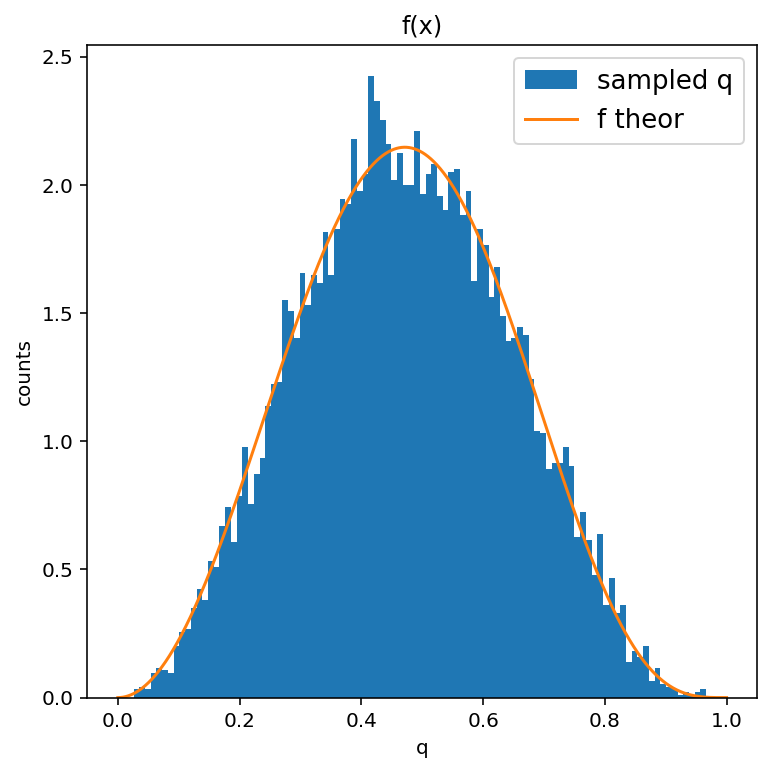

In [10]:
q_sample = np.array(q_sample)

plt.figure(figsize=(6, 6))
plt.hist(q_sample,100, density=True, label='sampled q')
plt.plot(q,pdf, label='f theor')
plt.xlabel('q')
plt.ylabel('counts')
plt.title('f(x)')
plt.legend(fontsize=13);

In [11]:
v = q_sample * np.sqrt(2 * Psi)
v_theta_cdf = np.random.uniform(0,1,N)
v_theta = np.arccos(1 - 2 * v_theta_cdf)
v_phi = np.random.uniform(0, 2 * np.pi, size=N) 


In [12]:
v_x = v * np.cos(v_phi) * np.sin(v_theta)
v_y = v * np.sin(v_phi) * np.sin(v_theta)
v_z = v * np.cos(v_theta)

We show the 3D simulation of the velocities.

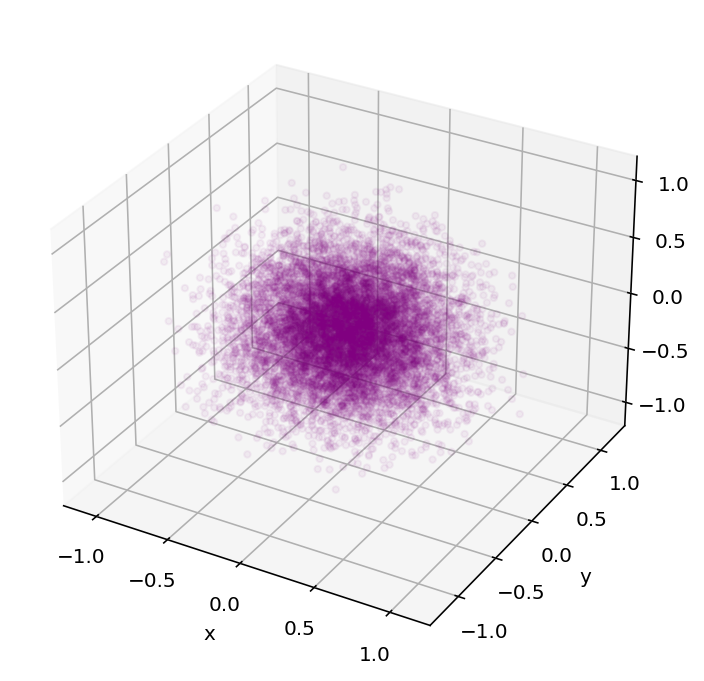

In [13]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
#ax.view_init(elev=90, azim=-90)
ax.scatter(v_x, v_y, v_z, c = 'purple', s=10.5, alpha = 0.05)
ax.set_aspect('auto')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#omega = np.linspace(0,2*np.pi,N)
#ax.plot(np.sqrt(2*np.max(Psi))*np.cos(omega),np.sqrt(2*np.max(Psi))*np.sin(omega), color='black', label='Q=1')
plt.show();

### Initial condition file

In [14]:
# creating the input file
m_arr = m 
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

# Data analysis

### Parameters

In [15]:
mask = R<b
V = 4/3 * np.pi * b**3
rho_ = np.sum(m_arr[mask])/ V
epsilon = 1/100 * (V/N)**(1/3)
T = np.sqrt(3 * np.pi/ (16* G * rho_))


print('Dynamical time:', T*20)

Dynamical time: 52.508555731501815


In [16]:
T_sim = 20 * T
print('Simulation time:', T_sim)

dt = 1/16
print('Time step:', dt)

theta = 0.2
print('Theta:', theta)

t_out = dt
print('Terminal out:', t_out)

Simulation time: 52.508555731501815
Time step: 0.0625
Theta: 0.2
Terminal out: 0.0625


---
### Running the code
Execute this cell only for new analysis!

---

### Fetching the data

We are also re-setting some of the constants that we might have changed throughout the code.

In [17]:
M = 1
N = 10**4 + 1
b = 1
m = M/N * np.ones(N)
G = 1
m_bh = 0.03*M
M = m_bh + m[1]*(N-1)
m[0] = 0*m[0] + m_bh
filename = glob.glob('outdata*')
print(filename)

['outdata_10001_0.2_0.0625_0.03_52.78947074725871.txt', 'outdata_10001_0.2_0.0625_0.02_51.42799643114692.txt', 'outdata_10001_0.2_0.0625_0.01_53.07494314153892.txt', 'outdata.txt', 'outdata_10001_0.2_0.0625_0.05_48.90482634259716.txt', 'outdata_10001_0.2_0.0625_0.04_52.767129148989.txt', 'outdata_10001_0.2_0.0625_0.025_52.9241189004359.txt']


In [18]:
# reading the data from output-selected file

lines = pd.read_csv(filename[0], names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

### Centre of mass

We compute the centre of mass of the sistem. We show in a graph that it is not fixed in time.

In [19]:
def CoM_t(t_s, m_s, x_s, y_s, z_s):
    
    cm_t_x = [(np.sum(m_s[:, t] * x_s[:, t]) / M) for t in range(0, len(t_s))]
    cm_t_y = [(np.sum(m_s[:, t] * y_s[:, t]) / M) for t in range(0, len(t_s))]
    cm_t_z = [(np.sum(m_s[:, t] * z_s[:, t]) / M) for t in range(0, len(t_s))]
    
    return cm_t_x, cm_t_y, cm_t_z

In [20]:
# finding the centre of mass coordinates in time:

x_cm, y_cm, z_cm = CoM_t(t_s, m_s, x_s, y_s, z_s)
r_cm = np.sqrt(np.array(x_cm)**2 + np.array(y_cm)**2 + np.array(z_cm)**2)

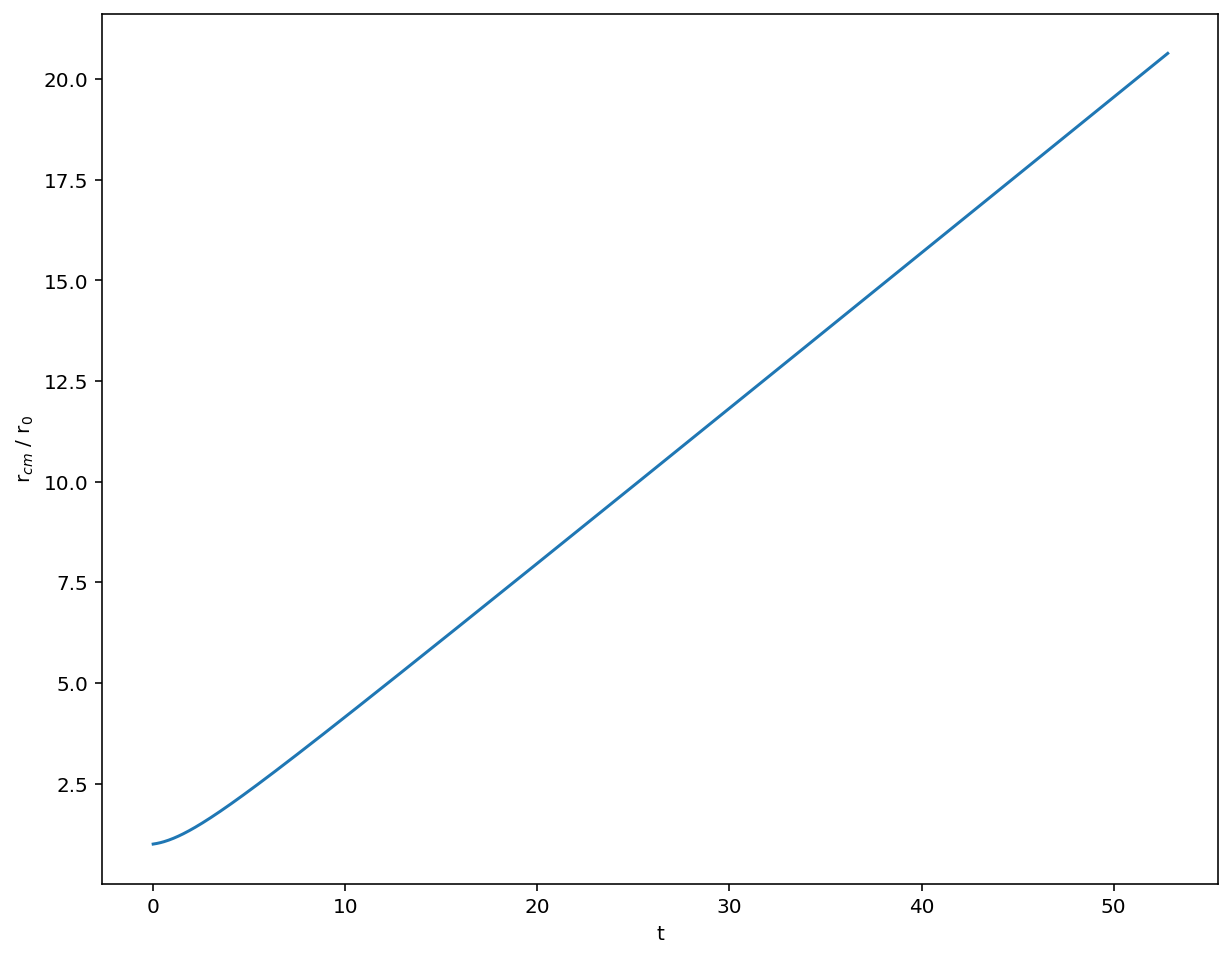

In [21]:
plt.figure(figsize=(10, 8))

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

We re-defined all the radii by correcting it by subtracting the centre of mass, so that the analysis is always carried out in that system of reference. 

In [22]:
r = np.sqrt((x_s-x_cm)**2 + (y_s-y_cm)**2 + (z_s-z_cm)**2)

### Density Profile

We analyzed the density profile for each timestep, starting by computing the volume of 1000 shells between zero and the maximum position of the particles. We, then, set a function in order to get the number of particles inside the shells at a fixed time.

We computed the density profile for each timestep, we sampled the mean density profile and its error by estimating the error on the number of particles obtained by the simulation.
In the end we quantified the propagation of the error to the density and we plotted the result.
In order to compute the average number of particles inside each shell by using the analytical density distribution we applied the following equation:

$$<particles> = \int_{r_1}^{r_2}4\pi r^2 \rho(r) dr$$
Note that the density profile of a Plummer sphere is:
$$\rho(r)=\frac{3M_{tot}}{4\pi b^3}\frac{1}{(1+\frac{r^2}{b^2})^{5/2}}$$
So the integral becomes
$$<particles> = \int_{r_1}^{r_2} \frac{3M_{tot}}{b^3} r^2 (1+\frac{r^2}{b^2})^{-5/2} dr = \frac{3M_{tot}}{b^3} \frac{r^3}{3(1+\frac{r^2}{b^2})^{3/2}}$$ evaluated between $r_1$ and $r_2$.

For each particle we took $1 \sigma$ as the error, since it is Poissonian we used the square root of the number of particles: $\sqrt{N}$. 
In the end we found the error propagation of the density.

In [23]:
r_t     = np.transpose(r)
sampl   = 200
alpha   = b/10
p_error = []
X       = np.linspace(b/10, 2 * b, sampl)
rho_t   = []
m_ = M/N

for i in range(len(r_t)):
    rho     = []
    tmp_err = []
    for x in X:
        dr      = alpha * x 
        r_min   = (x - dr/2)
        r_max   = (x + dr/2) 
        V_shell = 4 * np.pi * dr * x**2 #Calcolo i volume della shell
        mask    = (r_t[i] > r_min) * (r_t[i] < r_max) # prendo i raggi compresi tra r_min e r_max
        n       = len(r_t[i][mask])
        
        rho.append(n * m_ / V_shell) #len(r_t[i][mask] è il numero di particelle dentro la shell
        tmp_err.append(np.sqrt(n)*m_/V_shell)
   
    rho_t.append(rho)
    p_error.append(tmp_err)

In [24]:
p_error = np.array(p_error)
tmp_err = np.array(tmp_err)
rho_t   = np.array(rho_t) # densità a diversi tempi
rho     = np.array(rho) #denisità a tempo = T_sim
rho_th  = 3* M /(4*np.pi*b**3) * 1/(1+(X**2/b**2))**(5/2)
rho_c   = 3* M /(4*np.pi*b**3) #densità centrale

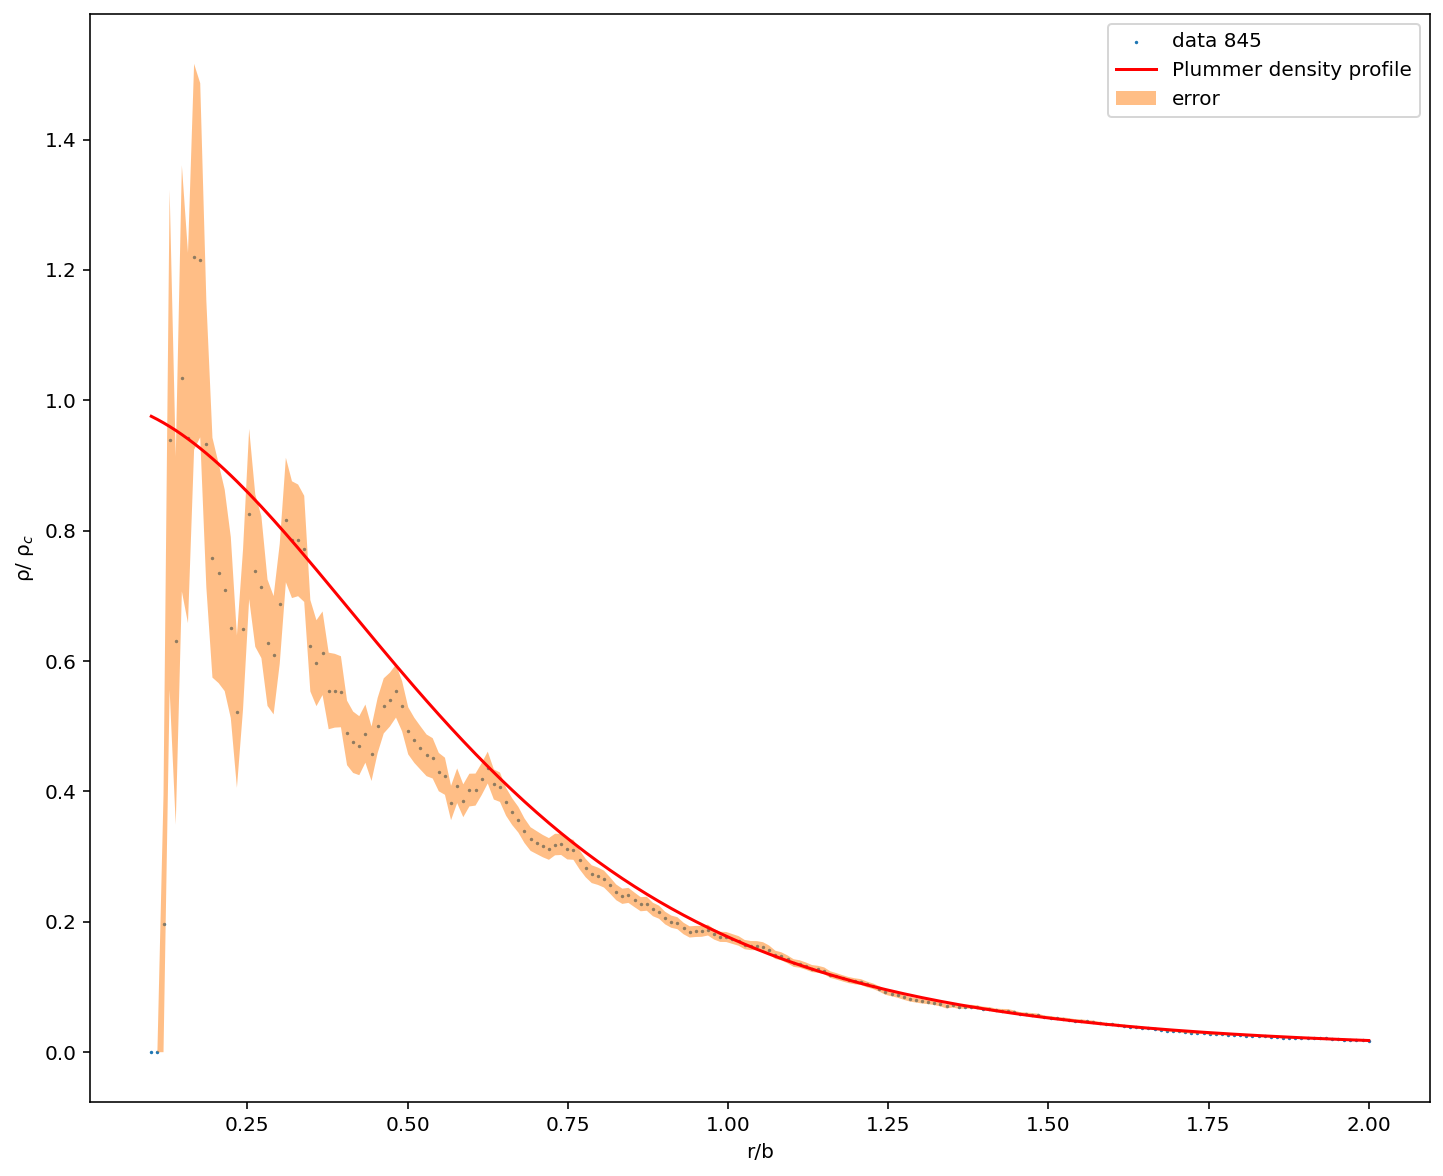

In [25]:
# plot of a single measurement at T = T_sim. I normalize at the central density
t= len(r_t)-1

plt.figure(figsize=(12, 10))

plt.scatter(X,rho_t[t]/rho_c, s=0.5,label= 'data '+str(t))
plt.plot(X,rho_th/rho_c, c='red', label= 'Plummer density profile') 
plt.fill_between(X, rho_t[t]/rho_c - p_error[t]/rho_c, rho_t[t]/rho_c + p_error[t]/rho_c, alpha= 0.5, label= 'error')
#plt.yscale('log')
plt.ylabel('\u03C1/ \u03C1$_{c}$')
plt.xlabel('r/b')
plt.legend()
#plt.savefig('density_profile_t='+str(t)+'.eps', format='eps' )
plt.show()

We expect the data to converge to the analytical distribution, we then normalized for the central density profile.

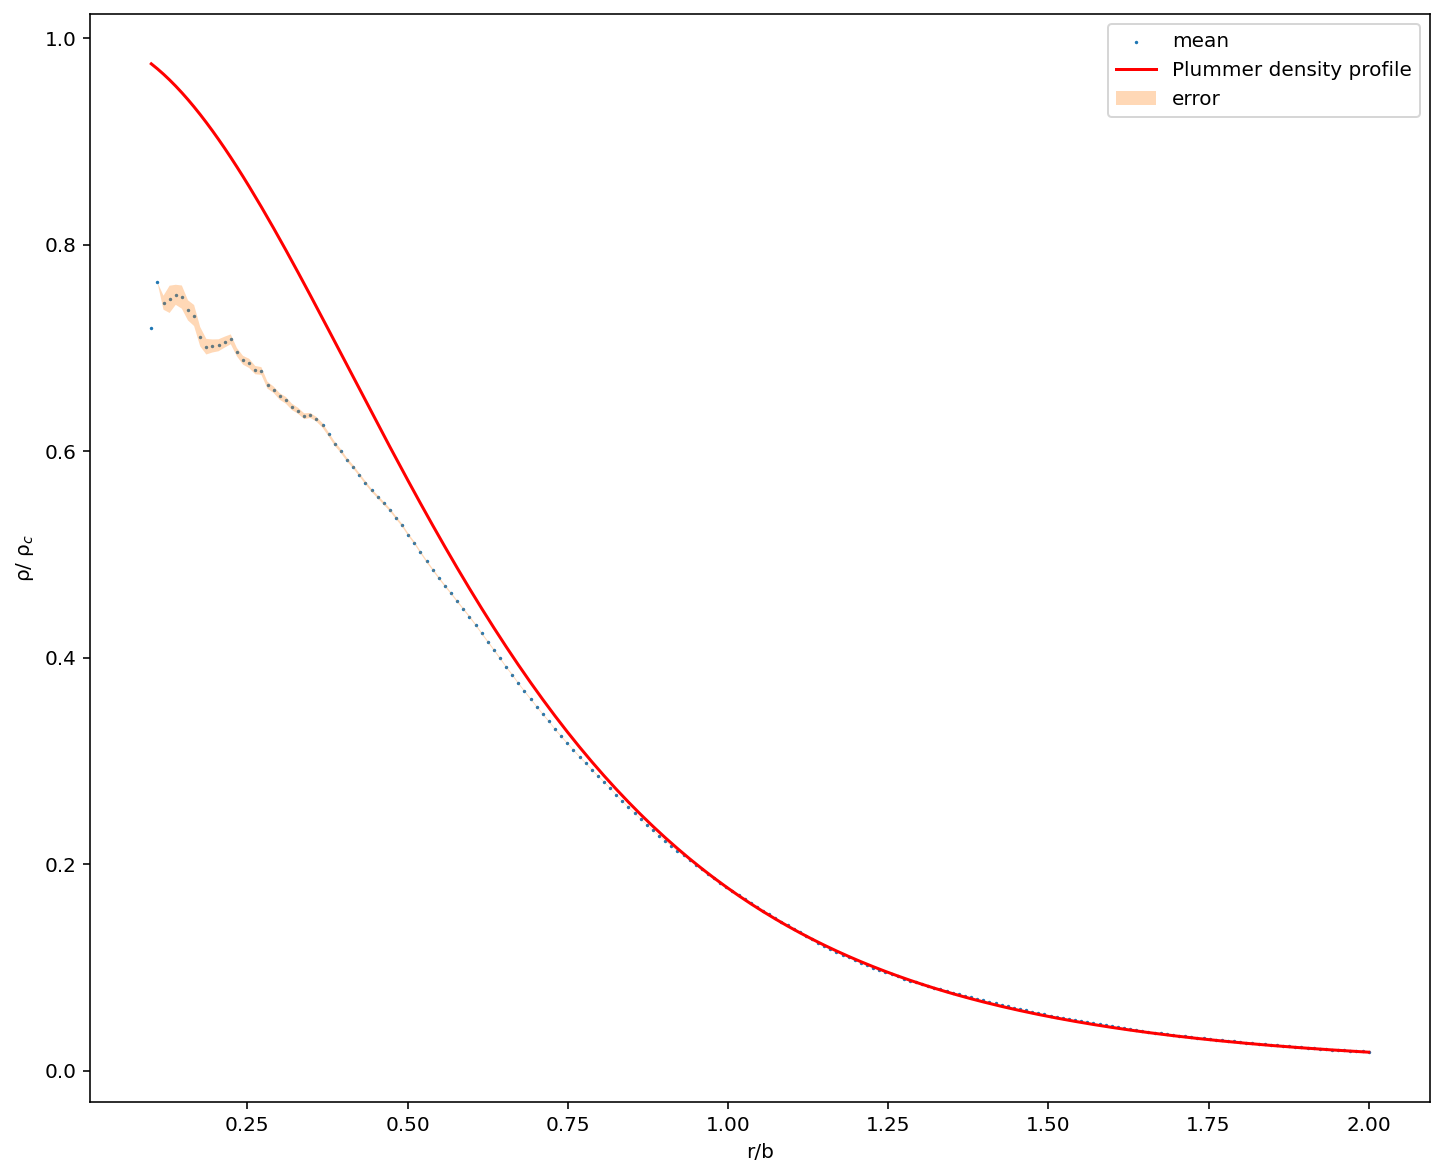

In [26]:
# I average in time the density
# I normalize by the central rho_c
rho_mean = np.mean(rho_t,axis=0)
error = p_error[t]/np.sqrt(len(rho_t))

plt.figure(figsize=(12, 10))

plt.scatter(X,rho_mean/rho_c, s=0.5, label= 'mean')
plt.plot(X,rho_th/rho_c, c='red', label= 'Plummer density profile') 
plt.fill_between(X/b, rho_mean/rho_c - error/rho_c, rho_mean/rho_c + error/rho_c, alpha= 0.3, label='error')
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('\u03C1/ \u03C1$_{c}$')
plt.xlabel('r/b')
plt.legend()
#plt.savefig('density_profile_mean.eps', format='eps' )
plt.show()

Underestimation due to the presence of the big mass in the centre we didn't take into account?

### Lagrangian Radii

We can introduce the Lagrangian Radii which are the radii containing a certain percentage of the total mass of the system (M_tot).
We checked if the radii are constant and we observed that they are not.

In [27]:
# notice: radius_array must be of shape [N_particles, N_time_output]
def Lagrangian_Radius(radius_array, quantile):
    
    L_radii = []
    
    # cycle over N_time_output
    for i in range(len(radius_array[0])):
        
        radii_sorted = np.sort(radius_array[:,i])
        mask = radii_sorted < np.quantile(radii_sorted, quantile)
        L_radii.append(np.max(radii_sorted[mask]))
        
    return np.array(L_radii)

# to find the lagrangian radius from theory

def Lagrangian_Theory(b, quantile): 
    
    rad3_cb3 = (quantile * b**3)**(1/3)
    
    return rad3_cb3 / (1 - 1 / b**2 * rad3_cb3**2)**(1/2)

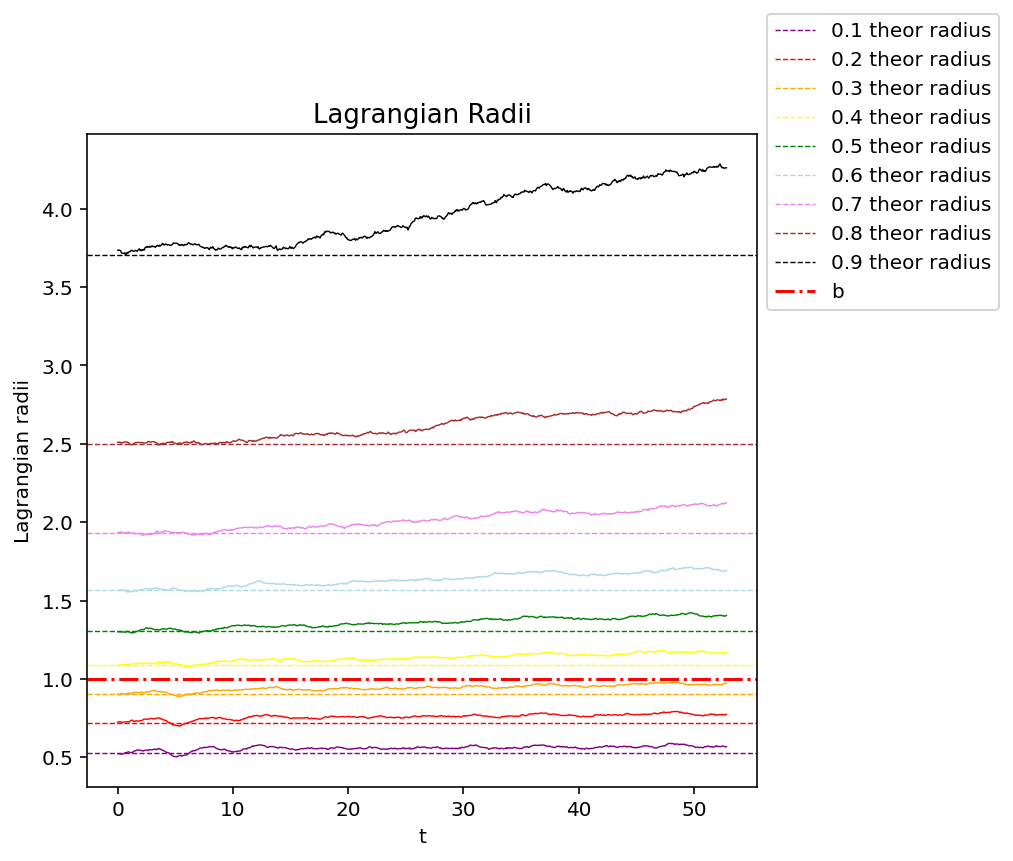

In [28]:
quantiles = np.linspace(0.1, 0.9, 9)

std = []

c = ['purple', 'red', 'orange', 'yellow', 'green', 'lightblue', 'violet', 'brown', 'black']

plt.figure(figsize=(6, 6))

for q, color in zip(quantiles, c):
    
    L = Lagrangian_Radius(r, round(q,1))
    std.append(np.var(L)**0.5)
    
    #plt.plot(t_s, L, label='q ='+str(round(q,1)))  , yerr=std[-1], xerr=None
    plt.plot(t_s, L, c=color, linewidth=0.7, alpha=1)   
    plt.axhline(Lagrangian_Theory(b, q), linestyle='--', label=f'{q:.1f} theor radius', c=color, linewidth=0.7, alpha=1)
    
plt.axhline(b, label='b', color='red', linestyle='-.')
plt.ylabel('Lagrangian radii')
plt.xlabel('t')
plt.title('Lagrangian Radii', fontsize=13)
plt.legend(bbox_to_anchor=(1., 1.2));

### Perturber velocity and orbit

In [29]:
def find_vs_module(vx_s, vy_s, vz_s): 
    
    return np.sqrt(vx_s**2 + vy_s**2 + vz_s**2)

In [30]:
mod_v_s = find_vs_module(vx_s, vy_s, vz_s)

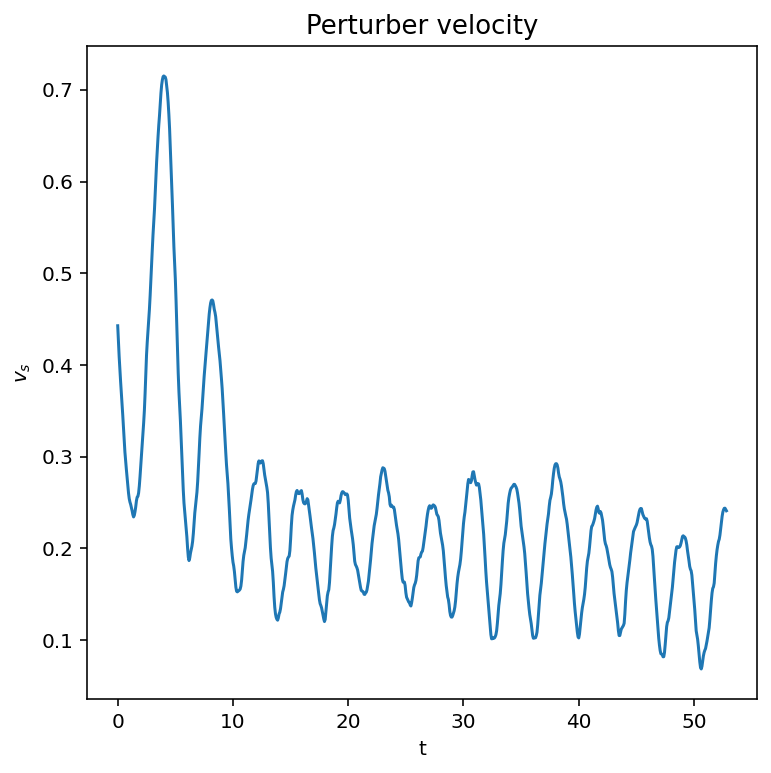

In [31]:
plt.figure(figsize=(6, 6))

plt.plot(t_s, mod_v_s[0])
plt.ylabel('$v_s$')
plt.xlabel('t')
plt.title('Perturber velocity', fontsize=13); 

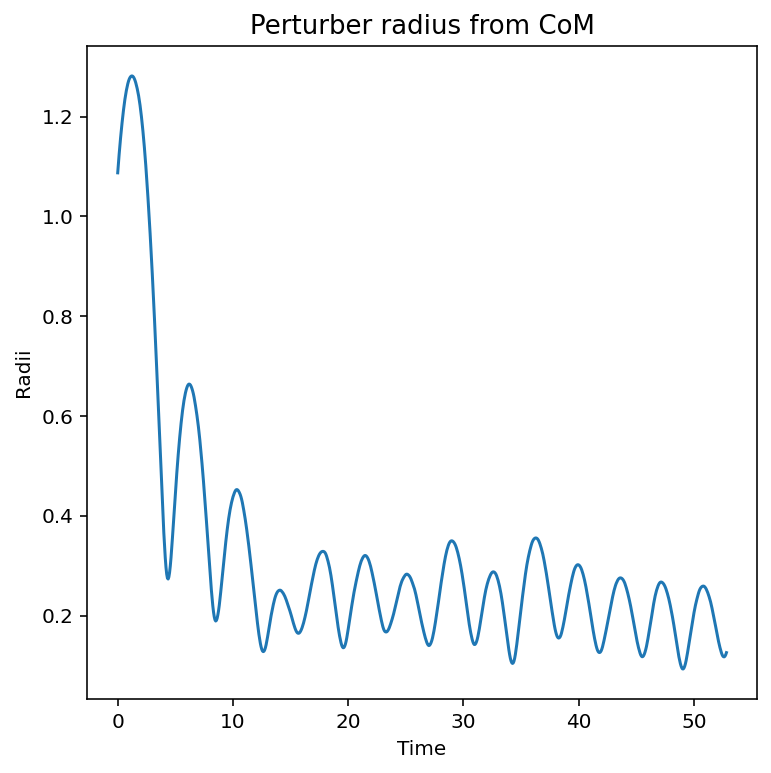

In [32]:
plt.figure(figsize=(6, 6))

plt.plot(t_s,r[0]/b)
plt.xlabel('Time')
plt.ylabel('Radii')
plt.title('Perturber radius from CoM', fontsize=13); 

The orbits can be seen by plotting in 2D or even 3D:

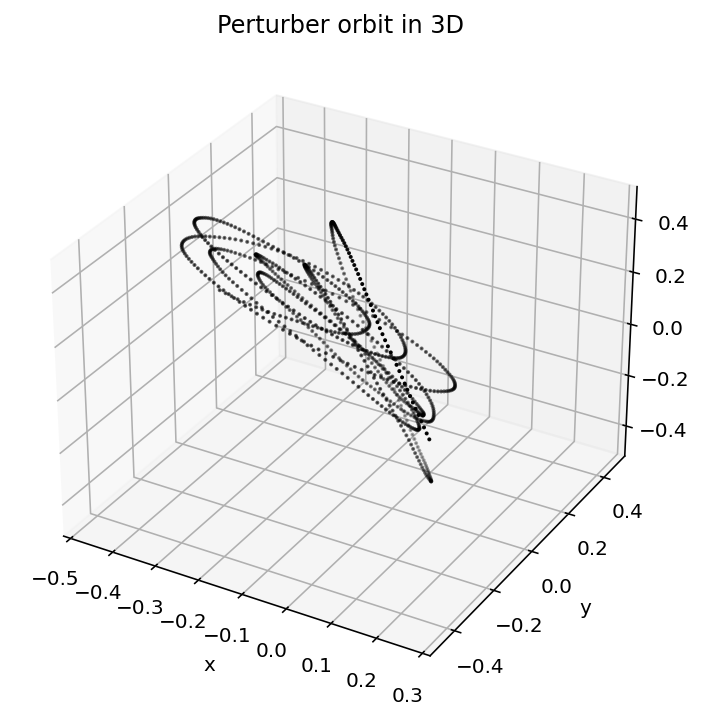

In [33]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_s[0, :], y_s[0, :], z_s[0, :], c = 'black', s=1)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Perturber orbit in 3D')
ax.set_xlim(-0.5, 0.3)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.5, 0.5)
plt.show();

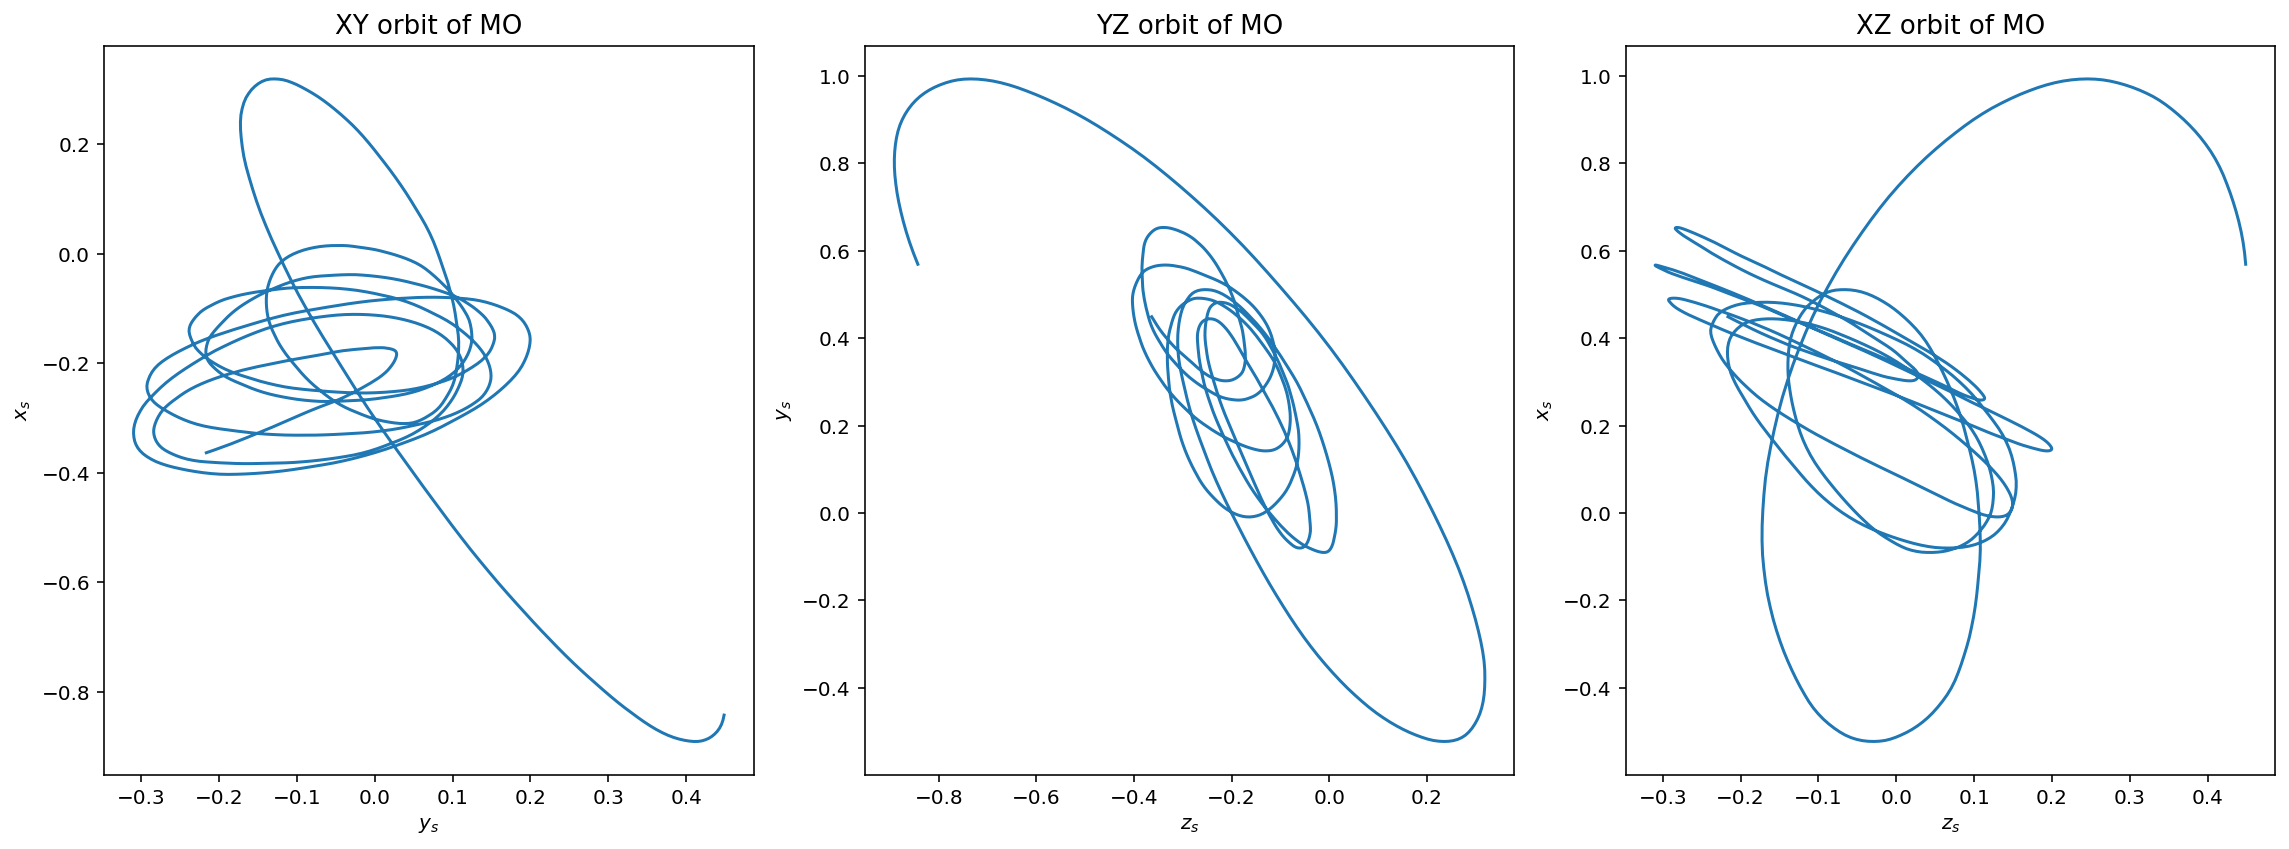

In [34]:
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(16, 6)) 

ax[0].plot(x_s[0, :], y_s[0, :])
ax[0].set_ylabel('$x_s$')
ax[0].set_xlabel('$y_s$')
ax[0].set_title('XY orbit of MO', fontsize=13)

ax[1].plot(y_s[0, :], z_s[0, :])
ax[1].set_ylabel('$y_s$')
ax[1].set_xlabel('$z_s$')
ax[1].set_title('YZ orbit of MO', fontsize=13)

ax[2].plot(x_s[0, :], z_s[0, :])
ax[2].set_ylabel('$x_s$')
ax[2].set_xlabel('$z_s$')
ax[2].set_title('XZ orbit of MO', fontsize=13); 

We found the average radii and time and we plotted the result over the previous graph, using the definition of mean value of a function over an interval: 

$$<R> = \frac{1}{t_{max} - t_{min}} \int_{t_{min}}^{t_{max}} r(t) dt $$

In [35]:
def find_average_r_nice(r_s, N_intervals): 
    
    r_mean = []
    t_mean = []
    
    step = int(len(t_s)/N_intervals)
    remaining = len(t_s)%N_intervals

    for n in np.arange(0, len(t_s) - remaining, step):
        
        tmin = t_s[n]
        tmax = t_s[n+step]
        
        r_mean.append(1/(tmax-tmin) * np.trapz(r_s[n:n+step], t_s[n:n+step]))
        t_mean.append((tmax + tmin)/2)
        
    return t_mean, r_mean

In [36]:
 t_mean, r_mean = find_average_r_nice(r[0]/b, 20)

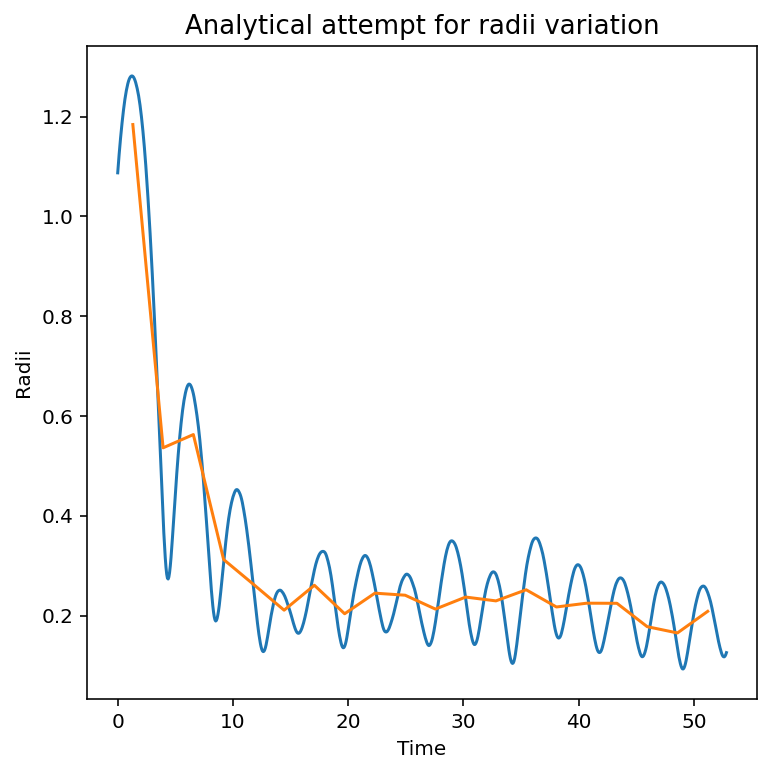

In [37]:
plt.figure(figsize=(6, 6))

plt.plot(t_s,r[0]/b)
plt.plot(t_mean, r_mean)
plt.xlabel('Time')
plt.ylabel('Radii')
plt.title('Analytical attempt for radii variation', fontsize=13); 

In [38]:
def find_t_qualitative(t_mean, r_mean): 
    
    t_arg = np.argwhere(np.array(r_mean) < 0.2 * (r[0]/b)[0])[0][0]  # when 20% of the initial radius
    
    return t_mean[t_arg]

We defined the collapse time. 

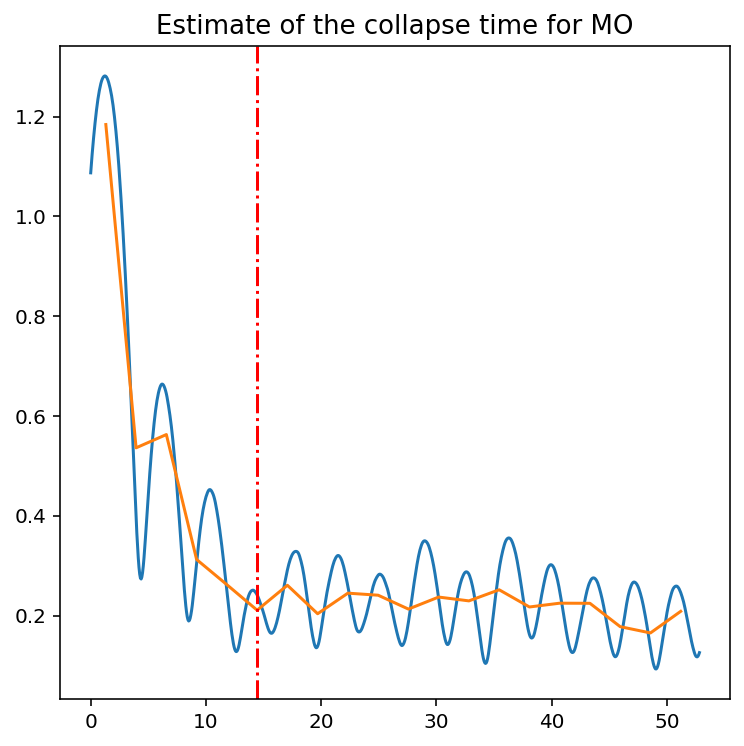

In [39]:
time_coll = find_t_qualitative(t_mean, r_mean)

plt.figure(figsize=(6, 6))

plt.plot(t_s,r[0]/b)
plt.plot(t_mean, r_mean)
plt.axvline(find_t_qualitative(t_mean, r_mean), c='r', linestyle='-.')
plt.title('Estimate of the collapse time for MO', fontsize=13);

In [40]:
print("The mass of the BH is:", m_bh)
print("The collapse time is:", time_coll)

The mass of the BH is: 0.03
The collapse time is: 14.4375


### Angular Momentum

In the end we studied the evolution of the angular momentum of the perturber.
$$L = Mrv$$
With M the mass of the perturber, r the radius of the perturber and v the velocity of the perturber corrected with the centre of mass.

In [41]:
def find_L(r_s, M, v_s):
    
    return M * r_s * v_s

In [42]:
l_s = find_L(r[0], m_bh, mod_v_s[0])

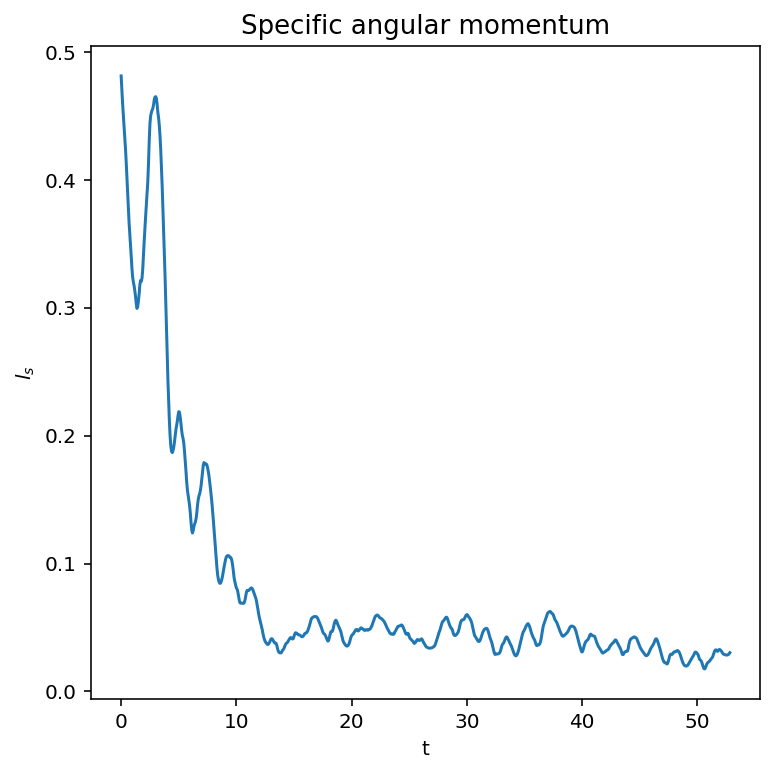

In [43]:
plt.figure(figsize=(6, 6))
plt.plot(t_s,l_s/m_bh)

plt.ylabel('$l_s$')
plt.xlabel('t')
plt.title('Specific angular momentum', fontsize=13);

### T(M)

Now we wanted to show how the collapse time changes respect to the mass of the perturber. We choose different masses for the perturber and we computed its collapse time, we then plotted in a graph the result.

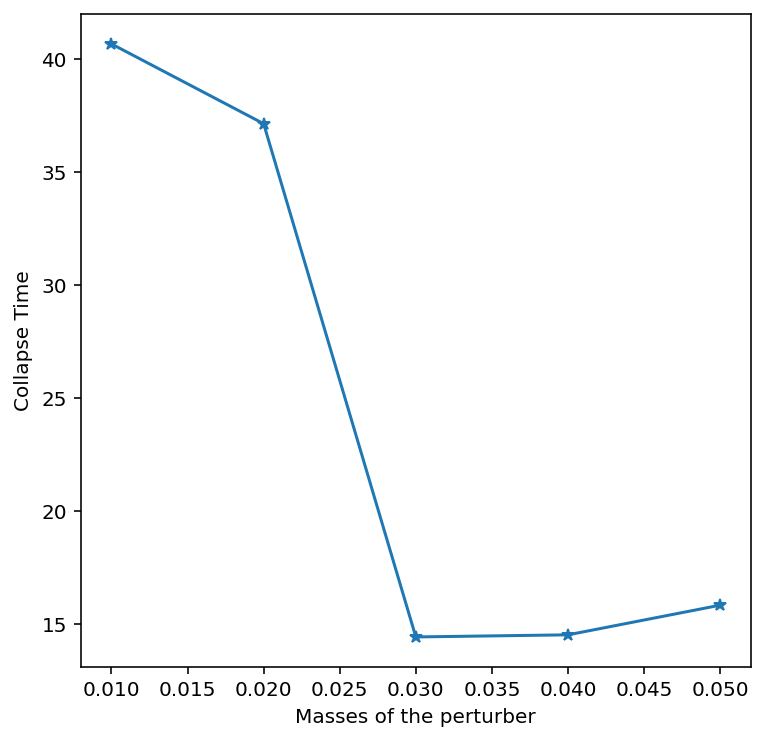

In [44]:
m_bh_arr = [0.01, 0.02, 0.03, 0.04, 0.05]
t_coll_arr = [40.6875, 37.15625, 14.4375, 14.53125, 15.84375]

#graph of the trend 
plt.figure(figsize=(6, 6))
plt.plot(m_bh_arr, t_coll_arr, marker='*')
plt.xlabel('Masses of the perturber')
plt.ylabel('Collapse Time')
plt.show()

From the previous graph we can observe that the collapse time tends to become shorter while the mass increase. 
Even though we can clearly see by eye that the last collapse time slightly increase instead of decreasing, this is due probably to the fact that every time we start a simulation with different masses of the perturber, it does not start from the same position, or it could be due to some overstimation of the parameters.

## Animation

100%|████████████████████████████████████████▉| 845/846 [07:19<00:00,  2.09it/s]

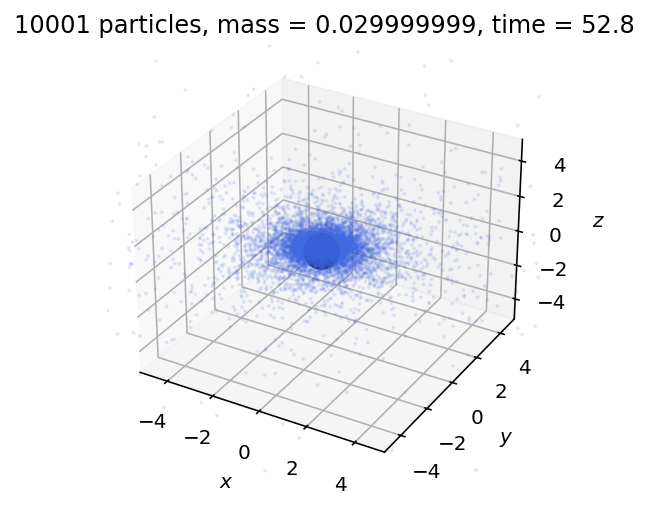

In [45]:
# simulation
from matplotlib import animation
from tqdm import tqdm

def update(num):
    global N    #N_particles
    l = 5
    ax.clear()
    ax.scatter(x_s[0:1,num-1], y_s[0:1,num-1], z_s[0:1,num-1], color = 'black', s = m_bh/m[2] ,alpha = 1 )
    ax.scatter(x_s[1:2,num-1], y_s[1:2,num-1], z_s[1:2,num-1], color = 'royalblue', s = 1 ,alpha = 0.1 )
    ax.scatter(x_s[2:,num-1], y_s[2:,num-1], z_s[2,num-1], color = 'royalblue' , s = 1 ,alpha = 0.1 )        # Updating Point Location

    ax.set_title(f'{N} particles, mass = {m_s[0,0]}, time = {round(t_s[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='auto')
line_ani = animation.FuncAnimation(fig, update, interval=1,   
                                   frames=tqdm(range(len(t_s))))

# Saving the Animation
f = r"sphere_1.gif"
writergif = animation.PillowWriter(fps=30)
line_ani.save(f, writer=writergif, dpi=200)

plt.show()